In [18]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [19]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html


In [20]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 11872, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11872 (delta 3), reused 2 (delta 0), pack-reused 11862
Receiving objects: 100% (11872/11872), 15.03 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (8687/8687), done.
/content/mmsegmentation/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation/mmsegmentation
  Attempting uninstall: mmsegmentation
    Found existing installation: mmsegmentation 0.29.0
    Can't uninstall 'mmsegmentation'. No files were found to uninstall.
  Running setup.py develop for mmsegmentation


In [21]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.0


In [22]:
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2022-10-12 19:05:42--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  3.81MB/s    in 4.0s    

2022-10-12 19:05:47 (3.48 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



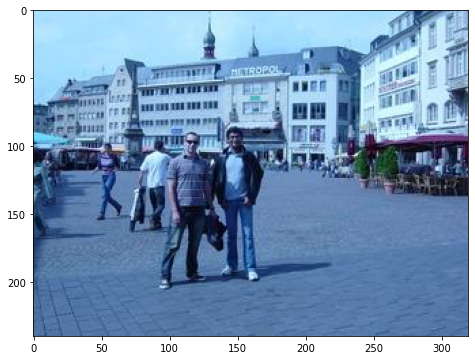

In [23]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/mmsegmentation/iccv09Data/images/0000047.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [24]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/mmsegmentation/iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
                                                         '.png')))

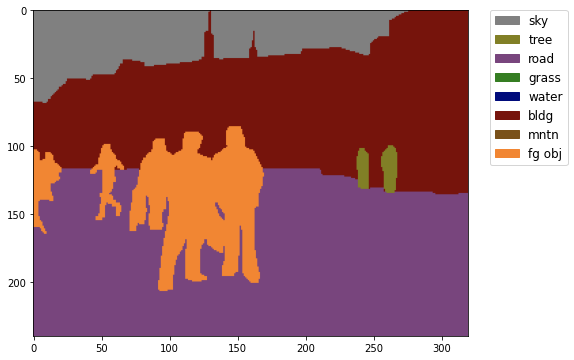

In [25]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/mmsegmentation/iccv09Data/labels/0000047.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [26]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [27]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class Data(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

KeyError: ignored

In [28]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/unet/fcn_unet_s5-d16_64x64_40k_drive/fcn_unet_s5-d16_64x64_40k_drive_20201223_191051-5daf6d3b.pth -P checkpoints

--2022-10-12 19:07:07--  https://download.openmmlab.com/mmsegmentation/v0.5/unet/fcn_unet_s5-d16_64x64_40k_drive/fcn_unet_s5-d16_64x64_40k_drive_20201223_191051-5daf6d3b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.74.197.92
Connecting to download.openmmlab.com (download.openmmlab.com)|47.74.197.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116332552 (111M) [application/octet-stream]
Saving to: ‘checkpoints/fcn_unet_s5-d16_64x64_40k_drive_20201223_191051-5daf6d3b.pth’

fcn_unet_s5-d16_64x 100%[===================>] 110.94M  11.3MB/s    in 9.7s    

2022-10-12 19:07:17 (11.5 MB/s) - ‘checkpoints/fcn_unet_s5-d16_64x64_40k_drive_20201223_191051-5daf6d3b.pth’ saved [116332552/116332552]



In [29]:
from mmcv import Config
cfg = Config.fromfile('/content/mmsegmentation/configs/unet/fcn_unet_s5-d16_64x64_40k_drive.py')

In [30]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'Data'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = 'content/work_dirs/tutorial'

cfg.runner.max_iters = 400
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type=

In [31]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-10-12 19:08:34,670 - mmseg - INFO - Loaded 572 images
2022-10-12 19:08:35,118 - mmseg - INFO - Loaded 143 images
2022-10-12 19:08:35,120 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-10-12 19:08:35,240 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 64, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 64, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 3.7 task/s, elapsed: 38s, ETA:     0s

2022-10-12 19:11:03,068 - mmseg - INFO - per class results:
2022-10-12 19:11:03,071 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  Dice |  Acc  |
+--------+-------+-------+
|  sky   | 70.71 | 74.26 |
|  tree  | 40.33 | 31.46 |
|  road  | 63.68 | 61.59 |
| grass  | 61.17 | 75.18 |
| water  |  5.45 |  2.84 |
|  bldg  |  53.8 | 71.58 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 35.53 | 30.43 |
+--------+-------+-------+
2022-10-12 19:11:03,073 - mmseg - INFO - Summary:
2022-10-12 19:11:03,077 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 53.45 | 41.33 | 43.42 |
+-------+-------+-------+
2022-10-12 19:11:03,081 - mmseg - INFO - Iter(val) [143]	aAcc: 0.5345, mDice: 0.4133, mAcc: 0.4342, Dice.sky: 0.7071, Dice.tree: 0.4033, Dice.road: 0.6368, Dice.grass: 0.6117, Dice.water: 0.0545, Dice.bldg: 0.5380, Dice.mntn: 0.0000, Dice.fg obj: 0.3553, Acc.sky: 0.7426, Acc.tree: 0.3146, Acc.road: 0.6159, Acc.grass: 0.7518, Acc.water: 0.0284, Acc.bl

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 3.8 task/s, elapsed: 38s, ETA:     0s

2022-10-12 19:13:33,447 - mmseg - INFO - per class results:
2022-10-12 19:13:33,450 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  Dice |  Acc  |
+--------+-------+-------+
|  sky   | 81.15 |  92.8 |
|  tree  | 58.87 | 53.67 |
|  road  | 64.88 | 56.69 |
| grass  | 72.36 | 66.72 |
| water  | 29.24 | 17.93 |
|  bldg  | 57.48 | 79.04 |
|  mntn  |  0.0  |  0.0  |
| fg obj | 39.51 | 31.56 |
+--------+-------+-------+
2022-10-12 19:13:33,452 - mmseg - INFO - Summary:
2022-10-12 19:13:33,456 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 60.21 | 50.44 | 49.8 |
+-------+-------+------+
2022-10-12 19:13:33,463 - mmseg - INFO - Iter(val) [143]	aAcc: 0.6021, mDice: 0.5044, mAcc: 0.4980, Dice.sky: 0.8115, Dice.tree: 0.5887, Dice.road: 0.6488, Dice.grass: 0.7236, Dice.water: 0.2924, Dice.bldg: 0.5748, Dice.mntn: 0.0000, Dice.fg obj: 0.3951, Acc.sky: 0.9280, Acc.tree: 0.5367, Acc.road: 0.5669, Acc.grass: 0.6672, Acc.water: 0.1793, Acc.bldg: 0

<Figure size 576x432 with 0 Axes>

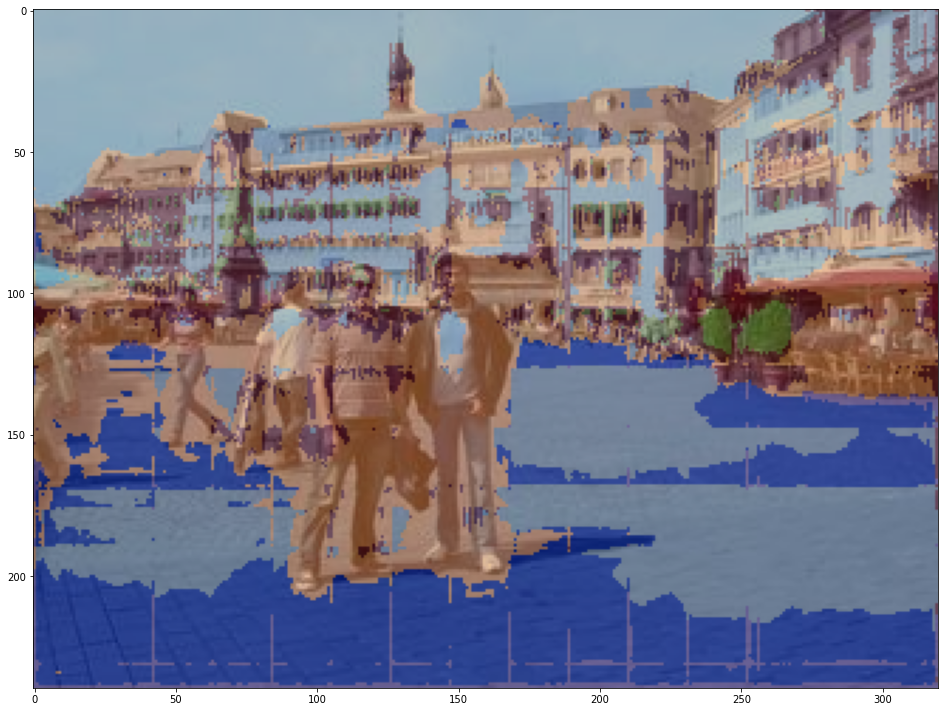

In [32]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('/content/mmsegmentation/iccv09Data/images/0000047.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)

plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)